## Domestic COVID Data Analysis 

In this notebook, we analyze U.S. COVID data from various sources.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# CDC Data Import

df_vacc_up_cdc = pd.read_csv(
    "../../data/cdc/COVID-19_Vaccinations_in_the_United_States_County.csv"
)
df_vacc_up_cdc["Date"] = pd.to_datetime(df_vacc_up_cdc["Date"], format="%m/%d/%Y")

In [3]:
# JHU Data Import

df_vacc_up_jhu = pd.read_csv("../../data/jhu/people_vaccinated_us_timeline.csv")
df_vacc_up_jhu.rename(columns={"Province_State": "Recip_State"}, inplace=True)

In [4]:
# KFF Data Import

df_vacc_man = pd.read_csv(
    "../../data/kff/vaccine_mandates.csv", skiprows=[0, 1, 3, 55, 56, 57, 58]
)

### Dictionary

In [5]:
# Dictionary for U.S. States

dict = {
    "AK": "Alaska",
    "AL": "Alabama",
    "AR": "Arkansas",
    "AS": "American Samoa",
    "AZ": "Arizona",
    "CA": "California",
    "CO": "Colorado",
    "CT": "Connecticut",
    "DC": "District of Columbia",
    "DE": "Delaware",
    "FL": "Florida",
    "GA": "Georgia",
    "HI": "Hawaii",
    "IA": "Iowa",
    "ID": "Idaho",
    "IL": "Illinois",
    "IN": "Indiana",
    "KS": "Kansas",
    "KY": "Kentucky",
    "LA": "Louisiana",
    "MA": "Massachusetts",
    "MD": "Maryland",
    "ME": "Maine",
    "MI": "Michigan",
    "MN": "Minnesota",
    "MO": "Missouri",
    "MS": "Mississippi",
    "MT": "Montana",
    "NC": "North Carolina",
    "ND": "North Dakota",
    "NE": "Nebraska",
    "NH": "New Hampshire",
    "NJ": "New Jersey",
    "NM": "New Mexico",
    "NV": "Nevada",
    "NY": "New York",
    "OH": "Ohio",
    "OK": "Oklahoma",
    "OR": "Oregon",
    "PA": "Pennsylvania",
    "RI": "Rhode Island",
    "SC": "South Carolina",
    "SD": "South Dakota",
    "TN": "Tennessee",
    "TX": "Texas",
    "UT": "Utah",
    "VA": "Virginia",
    "VT": "Vermont",
    "WA": "Washington",
    "WI": "Wisconsin",
    "WV": "West Virginia",
    "WY": "Wyoming",
}

df_vacc_up_cdc.replace({"Recip_State": dict}, inplace=True)

In [6]:
mandate = {
    "state": [
        "Oregon",
        "California",
        "Nevada",
        "Colorado",
        "New Mexico",
        "Minnesota",
        "New York",
        "New Jersey",
        "Delaware",
        "North Carolina",
        "Hawaii",
    ],
    "healthcare": [
        "Washington",
        "Oregon",
        "California",
        "Nevada",
        "Colorado",
        "New Mexico",
        "Illinois",
        "Maine",
        "New York",
        "Rhode Island",
        "New Jersey",
        "Delaware",
        "Maryland",
    ],
    "school": [
        "Washington",
        "Oregon",
        "California",
        "New Mexico",
        "Illinois",
        "New York",
        "Connecticut",
        "New Jersey",
        "Delaware",
        "Hawaii",
    ],
}

In [7]:
three_mandates = [
    "Oregon",
    "California",
    "New York",
    "Delaware",
    "New Mexico",
    "New Jersey",
]
two_mandates = ["Washington", "Colorado", "Nevada", "Hawaii", "Illinois"]
one_mandate = [
    "Connecticut",
    "Maryland",
    "Rhode Island",
    "Maine",
    "North Carolina",
    "Minnesota",
]

### Analysis

In [8]:
# Assign a new column dependent on how many mandates each state had


def label_mandate(row):
    if row["Recip_State"] in three_mandates:
        return "3 Mandates"
    elif row["Recip_State"] in two_mandates:
        return "2 Mandates"
    elif row["Recip_State"] in one_mandate:
        return "1 Mandate"
    return "None"


df_vacc_up_jhu["Mandate"] = df_vacc_up_jhu.apply(lambda row: label_mandate(row), axis=1)

In [9]:
# Gather population total for each state (adding up all the county populations); assigned date does not change total

state_pop_raw = df_vacc_up_cdc.loc[df_vacc_up_cdc.Date == "2022-03-01"]
state_pop = state_pop_raw.groupby("Recip_State", as_index=False)["Census2019"].sum()

In [10]:
# Merge population totals to vaccine uptake dfs to get prevalence rather than raw totals


vacc_final = df_vacc_up_jhu.merge(state_pop, on="Recip_State", how="left")
vacc_final[["People_Fully_Vaccinated", "People_Partially_Vaccinated"]] = vacc_final[
    ["People_Fully_Vaccinated", "People_Partially_Vaccinated"]
].div(vacc_final["Census2019"], axis=0)

### Plots

In [11]:
# Pre-plot work to make graph prettier and df easier to work with

vacc_final["Month"] = pd.DatetimeIndex(vacc_final["Date"]).month
vacc_final["Year"] = pd.DatetimeIndex(vacc_final["Date"]).year

vacc_final["Month"] = vacc_final["Month"].replace(
    {
        1: "Jan",
        2: "Feb",
        3: "Mar",
        4: "Apr",
        5: "May",
        6: "Jun",
        7: "Jul",
        8: "Aug",
        9: "Sep",
        10: "Oct",
        11: "Nov",
        12: "Dec",
    }
)

vacc_final["Time"] = (
    vacc_final["Month"].astype(str) + " " + vacc_final["Year"].astype(str)
)

vacc_final.rename(columns={"level_0": "Mandate?"}, inplace=True)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

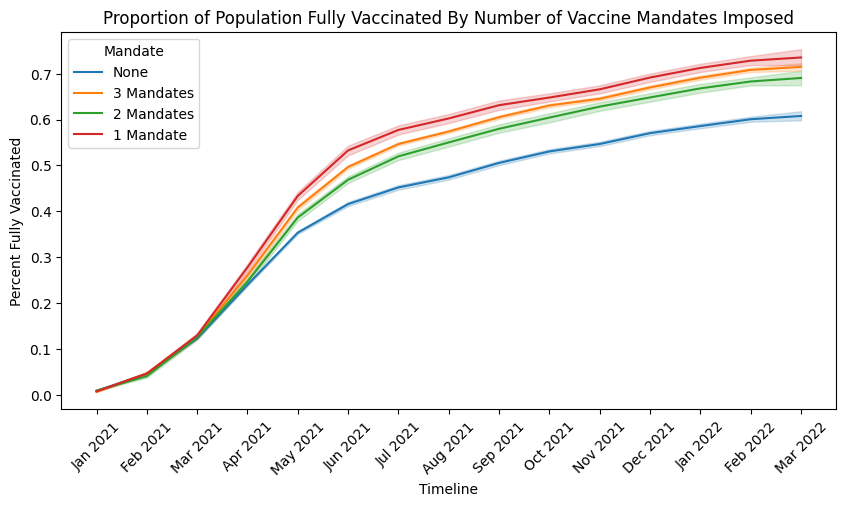

In [13]:
# JHU Vaccine Rates (based on Census 2019 Population) Dependent on Number of Mandates

fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

sns.lineplot(
    data=vacc_final,
    x="Time",
    y="People_Fully_Vaccinated",
    hue="Mandate",
    ci=95,
)

ax.set(xlabel="Timeline", ylabel="Percent Fully Vaccinated")
ax.set(
    title="Proportion of Population Fully Vaccinated By Number of Vaccine Mandates Imposed"
)
plt.xticks(rotation=45)